#Robust Deconvolution with Parseval Filterbanks
Rossen Nenov, Vincent Lostanlen, Peter Balazs

This python notebook is supplementary material to a submitted article.

## Experimental Set Up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.patches as patches

Initialization of the Kernel $\boldsymbol{h}$

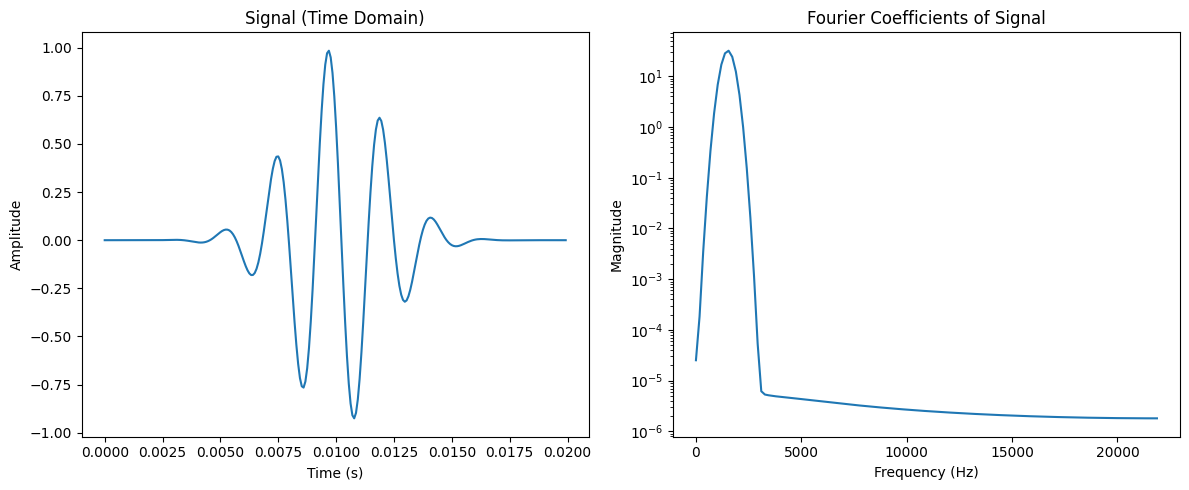

In [14]:
fs = 44100            # Sampling frequency (Hz)
power_of_2 = 8        # Power of 2 for the signal length
signal_length = 2**power_of_2   # Length of the signal
duration = 0.02       # Duration of the signal (seconds)
f0 = 440              # Fundamental frequency (Hz)
t = np.linspace(0, duration, signal_length, endpoint=False)


# Creation of the signal

gaussian_window = np.exp(-0.5 * ((t - duration / 2) / (duration / 10)) ** 2)
signal = np.sin(2 * np.pi * f0 * t) * gaussian_window

fourier_coefficients = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), d=1/fs)


# Visualize the Signal
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t, signal)
plt.title('Signal (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(1, 2, 2)
plt.plot(frequencies[:len(frequencies)//2],
         np.abs(fourier_coefficients[:len(fourier_coefficients)//2]))
plt.title('Fourier Coefficients of Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.yscale('log')

plt.tight_layout()

plt.show()


Set up of the Parseval Filterbank $\Psi$ with $J=7$ filters in the Fourier Domain:
For every $j\in[J]$ and $k \leq N/2$, $\boldsymbol{\hat{\psi}}_j[k] = 1$ if $2^j < k \leq 2^{j+1}$ and $0$ elsewhere.
For $k > N/2$, we complete the construction by Hermitian symmetry

This is a Parseval Filterbank


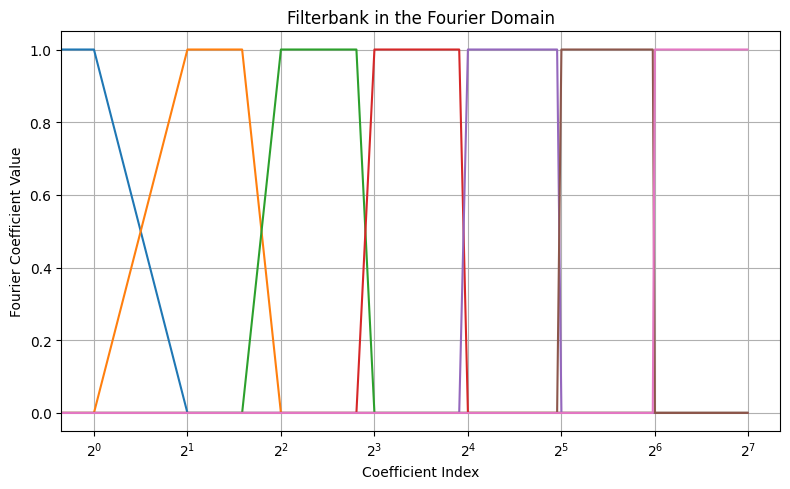

In [3]:
## Create Filterbank in the Fourier Domain for a signal of length 2**n

def create_Filterbank(power_of_2):
  length = 2**power_of_2
  n_filters = power_of_2 -1
  FFB = []
  FFB.append(np.array([1]*2 + [0] * (length-3) + [1]*(1)))

  for i in range(1,n_filters):
    FFB.append(np.array( [0] * (2**(i)) + [1]*(2**(i)) + [0] * (length -4* 2**(i)+1) + [1]*((2**(i)))+ [0]* (2**(i)-1) ))

  # Correction terms in the middle
  FFB[-1][2**(n_filters)]=1
  FFB[-1][2**(n_filters)+1]=1

  return FFB

def check_if_Parseval(FilterB):
  t_a = np.zeros(len(FilterB[0]))
  for phi in FilterB:
    t_a += np.abs(phi)**2
  if np.all(t_a==1):
    print("This is a Parseval Filterbank")
  else:
    print("This is not a Parseval Filterbank")

FilterB = create_Filterbank(8)
check_if_Parseval(FilterB)

# Plotting
x = np.arange(signal_length)[:signal_length//2]

plt.figure(figsize=(8, 5))

for idx, coeffs in enumerate(FilterB):
    plt.plot(x, coeffs[:signal_length//2], label=f'Signal {idx+1}')
plt.xlabel('Coefficient Index')
plt.xscale('log', base=2)
plt.ylabel('Fourier Coefficient Value')
plt.title('Filterbank in the Fourier Domain')
plt.grid(True)
plt.tight_layout()

plt.show()

We implement the proximal operator of $\lambda \|\cdot \|_2$:

In [4]:
def prox_l2(x, alpha):
    norm_x = np.linalg.norm(x)
    if norm_x == 0:
        return x        # Avoid division by zero
    return (max(0, 1 - alpha / norm_x)) * x

We implement everything in the Fourier Domain as the convolution is efficiently computed there and the DFT is a unitary transformation.

RDCP: $\min_{\boldsymbol{w}} \|\boldsymbol{w}\ast \boldsymbol{x} - \boldsymbol{y} \|_2^2 + \lambda \| \boldsymbol{w} \|_2 = \min_{{\boldsymbol{w}}} \|\hat{\boldsymbol{w}}\odot  \hat{\boldsymbol{x}} - \hat{\boldsymbol{y}} \|_2^2 + \lambda \| \hat{\boldsymbol{w}} \|_2$

In [5]:
#Define RDCP

def RDCP(W, X ,Y , reg_param):
  return 0.5*np.linalg.norm(W*X-Y)**2 + reg_param*np.linalg.norm(W)


# Define PGD for RDCP

def PGD(X,Y,reg_param,timing,upper):
  # X denotes the Fourier transform of x
  # Y denotes the Fourier transfrom of y
  # reg_param denotes the regularization parameter \lambda
  # timing defines for how long we want to run the algorithm in seconds
  # upper is the maximum amount of iterations

  # Initialize computations for faster gradient computations
  X2 = X*X.conj()
  Y2 = Y*X.conj()
  L = np.max(np.abs(X2))
  alpha = 1/(2*L)

  # Zero Initialization
  w_t = np.zeros(len(X),dtype="complex128")

  times   = [0]                    # Vector saving the times
  RDCP_list    = [RDCP(w_t, X ,Y , reg_param)]       # Vector saving the function values
  Ws      = [w_t]                  # Vector saving the current iterates

  # Initialize Timing
  absolute_start = time.perf_counter()
  end_it = absolute_start

  it = 0  # Count Iterates

  while times[-1] < timing:   # Set the maximal duration
      start_it = time.perf_counter()
      # Perform PGD Step
      w_t = prox_l2( w_t - alpha*( w_t*X2 - Y2 ) , alpha*reg_param )
      end_it = time.perf_counter()

      # Save values
      RDCP_list.append(RDCP(w_t, X ,Y , reg_param))
      Ws.append(w_t)
      times.append(end_it-start_it + times[-1])
      it +=1

  final_it = it   # Number of Iteration done in the defined time

  # Continue Computing until upper iteration bound is met
  # This is for the final reconstruction

  while it < upper:
      w_new = prox_l2( w_t - alpha*( w_t*X2 - Y2 ) , alpha*reg_param )
      it +=1
      if it % 100 == 0 and np.linalg.norm(w_new-w_t) < 1e-17:
        break
      w_t = w_new

  Final = RDCP(w_t,X,Y,reg_param)

  RDCP_list = (np.array(RDCP_list) - Final) / (RDCP_list[0] - Final)

  return [Ws,RDCP_list,times,final_it,w_t]



Similarly for Multi-RDCP:

In [6]:
def M_RDCP(W_js, X ,Y , FilterB,reg_params):
  a = 0
  if len(W_js)!= len(FilterB):
    print("Amount of w_j's does not match amount of filters.")
    return 0
  for j in range(len(FilterB)):
    L_j = np.max(np.abs(X*FilterB[j]))**2
    a+= 1/(2*L_j) * np.linalg.norm( FilterB[j] * W_js[j] * X  - L_j**0.5 * Y * FilterB[j])**2 + 1/L_j * reg_params[j] * np.linalg.norm(W_js[j])
  return a



def SNAKE(X,Y,reg_params,FilterB,timing,upper):
  # X denotes the Fourier transform of x
  # Y denotes the Fourier transfrom of y
  # reg_params denotes the regularization parameters \lambda_j
  # timing defines for how long we want to run the algorithm in seconds
  # upper is the maximum amount of iterations

  FilterB = np.array(FilterB)

  # Initialize computations for faster gradient computations
  P2_l = []
  X2_l = []
  L_l = []
  Y2_l = []
  for j in range(len(FilterB)):
      P2_l.append(FilterB[j]*FilterB[j].conj())
      X2_l.append(X*P2_l[j]*X.conj())
      L_l.append(np.max(np.abs(X2_l[j])))
      Y2_l.append(L_l[j]**(0.5)*Y*P2_l[j]*X.conj())


  # Zero Initialization
  W_F = [np.zeros(len(X),dtype="complex128")]*len(FilterB)
  times = [0]                     # Vector saving the times
  M_RDCP_list = [M_RDCP(W_F,X ,Y , FilterB,reg_params)]    # Vector saving the function values
  Ws = [W_F]                      # Vector saving the current iterates

  # Initialize Timing
  absolute_start = time.perf_counter()
  end_it = absolute_start

  it = 0  # Count Iterates
  while times[-1] < timing:
    start_it = time.perf_counter()
    for j in range(len(FilterB)):
      w_j = W_F[j].copy()

      alpha = 1/(2*L_l[j])
      w_j = prox_l2(w_j - alpha*(w_j*X2_l[j]-Y2_l[j]),alpha*reg_params[j])

      W_F[j]=w_j.copy()

    end_it = time.perf_counter()

    M_RDCP_list.append(M_RDCP(W_F,X ,Y , FilterB,reg_params))
    Ws.append(W_F)
    times.append(end_it-start_it+times[-1])
    it +=1

  final_it = it # Number of Iterations done in the defined time

  while it < upper:
    it+=1
    for j in range(len(FilterB)):
      w_j = W_F[j].copy()

      start_it = time.perf_counter()
      alpha = 1/(2*L_l[j])
      w_j = prox_l2(w_j - alpha*(w_j*X2_l[j]-Y2_l[j]),alpha*reg_params[j])
      end_it = time.perf_counter()

      W_F[j]=w_j.copy()

  Final = M_RDCP(W_F,X ,Y , FilterB,reg_params)
  # Reconstruct Final:
  W = np.zeros(len(X),dtype="complex128")
  for j in range(len(FilterB)):
    W += L_l[j]**(-0.5) * W_F[j] *FilterB[j] *FilterB[j].conj()

  M_RDCP_list = (np.array(M_RDCP_list) - Final) / (M_RDCP_list[0] - Final)

  return [Ws,M_RDCP_list,times,final_it,W]


Ridge Regression is given as: $\min_{\boldsymbol{w}} \|\boldsymbol{w}\ast \boldsymbol{x} - \boldsymbol{y} \|_2^2 + \lambda \| \boldsymbol{w} \|_2^2 = \min_{{\boldsymbol{w}}} \|\hat{\boldsymbol{w}}\odot  \hat{\boldsymbol{x}} - \hat{\boldsymbol{y}} \|_2^2 + \lambda \| \hat{\boldsymbol{w}} \|_2^2$, and its optimality criterion can be seen as:
$ (\hat{\boldsymbol{w}}\odot \hat{\boldsymbol{x}} - \hat{\boldsymbol{y}}) \odot \overline{\hat{\boldsymbol{x}}} + \lambda \hat{\boldsymbol{w}} = 0$, which can be solved pointwise.

We test for a given signal $\boldsymbol{h}$ via Golden Section Search, what $\lambda$ gives us the best possible $\boldsymbol{w}^* \approx \boldsymbol{h}$.

In [7]:
def reconstruction_accuracy(W,signal,Fourier):
  if Fourier == 1:
    return np.linalg.norm( W - np.fft.fft(signal))/np.linalg.norm(signal)
  else:
    return np.linalg.norm( W - signal)/np.linalg.norm(signal)

def Best_Ridge(signal, X, Y, max_lamb):
    tol = 1e-6
    low, high = 0, max_lamb

    # Define the objective function
    def objective(lamb):
        recon = Y * X.conj() / (X * X.conj() + lamb)
        return reconstruction_accuracy(recon, signal, 1)

    # Golden section search constants
    r = (5**0.5 - 1) / 2

    # Initial interior points based on the golden section
    x1 = low + (1 - r) * (high - low)
    x2 = low + r * (high - low)
    f1 = objective(x1)
    f2 = objective(x2)

    while high - low > tol:
        if f1 < f2:
            # The minimum lies in [low, x2]
            high = x2
            x2 = x1
            f2 = f1
            x1 = low + (1 - r) * (high - low)
            f1 = objective(x1)
        else:
            # The minimum lies in [x1, high]
            low = x1
            x1 = x2
            f1 = f2
            x2 = low + r * (high - low)
            f2 = objective(x2)

    best_lamb = (low + high) / 2
    best_recon = Y * X.conj() / (X * X.conj() + best_lamb)
    best_score = objective(best_lamb)

    # Set Acc=0 if best_lamb is effectively max_lamb, otherwise 1
    Acc = 0 if abs(best_lamb - max_lamb) < tol else 1

    return best_lamb, best_recon, best_score, Acc

Reproduce our Experiments:
100 Instances of Deconvolution

In [9]:
# This function normalizes the Function Values Vector to evenly spaced time intervals
def normalize(times, values, n, d):
    interpolated_values = []
    common_time = np.linspace(0, n, d)
    for tt in common_time:
        index = np.argmin(np.abs(times - tt))
        interpolated_values.append(values[index])
    return common_time, np.array(interpolated_values)

# Initialize lists to store results
noisy_signals, snake_losses, pgd_losses, snake_iterations, ridge_scores = [], [], [], [], []
snake_reconstructions, pgd_reconstructions, pgd_iterations, ridge_reconstructions = [], [], [], []

timed = 1
np.random.seed(42)

for ii in range(1, 101):  # Loop from 1 to 100
    # Overwrite the previous print output
    sys.stdout.write(f"\r{ii} Done Out of 100")
    sys.stdout.flush()

    # Generate white noise and compute cumulative sum
    white_noise = np.random.normal(0, 1, len(signal))
    cumulative_signal = np.cumsum(white_noise)

    # Apply Fourier transforms
    X = np.fft.fft(cumulative_signal)
    W = np.fft.fft(signal)
    Y_clean = W * X

    # Add noise to the signal
    y = np.fft.ifft(Y_clean).real
    noise = np.random.normal(0, 1, len(signal))
    y += 0.05 * np.linalg.norm(cumulative_signal) / np.linalg.norm(noise) * noise

    # Inverse FFT to get the noisy signal
    Y = np.fft.fft(y)
    noisy_signals.append(np.fft.ifft(Y / X).real)

    # SNAKE algorithm
    reg_params = [np.linalg.norm(cumulative_signal) * 150] * 10

    Ws, M_RDCP_list, times, final_it, Wj = SNAKE(X, Y, reg_params, FilterB, timed, 10**3)
    _, snake_loss = normalize(times, M_RDCP_list, timed, 1000)
    snake_reconstructions.append(Wj)
    snake_losses.append(snake_loss)
    snake_iterations.append(final_it)

    # Projected Gradient Descent (PGD)
    reg_param = 40 * np.linalg.norm(cumulative_signal)

    upper = 10**5
    Ws, RDCP_list, times2, final_it2, pgd_recon = PGD(X, Y, reg_param, timed, upper)
    _, pgd_loss = normalize(times2, RDCP_list, timed, 1000)
    pgd_reconstructions.append(pgd_recon)
    pgd_losses.append(pgd_loss)
    pgd_iterations.append(final_it2)

    # Ridge Regression
    max_lamb = 10**5
    best_lamb, recon, best_score, accuracy = Best_Ridge(signal, X, Y, max_lamb)
    if accuracy == 0:
        print("\nWarning: Ridge did not find the best in the interval.")

    ridge_reconstructions.append(recon)
    ridge_scores.append(best_score)

# Ensure the final progress is printed on a new line
print()


100 Done Out of 100


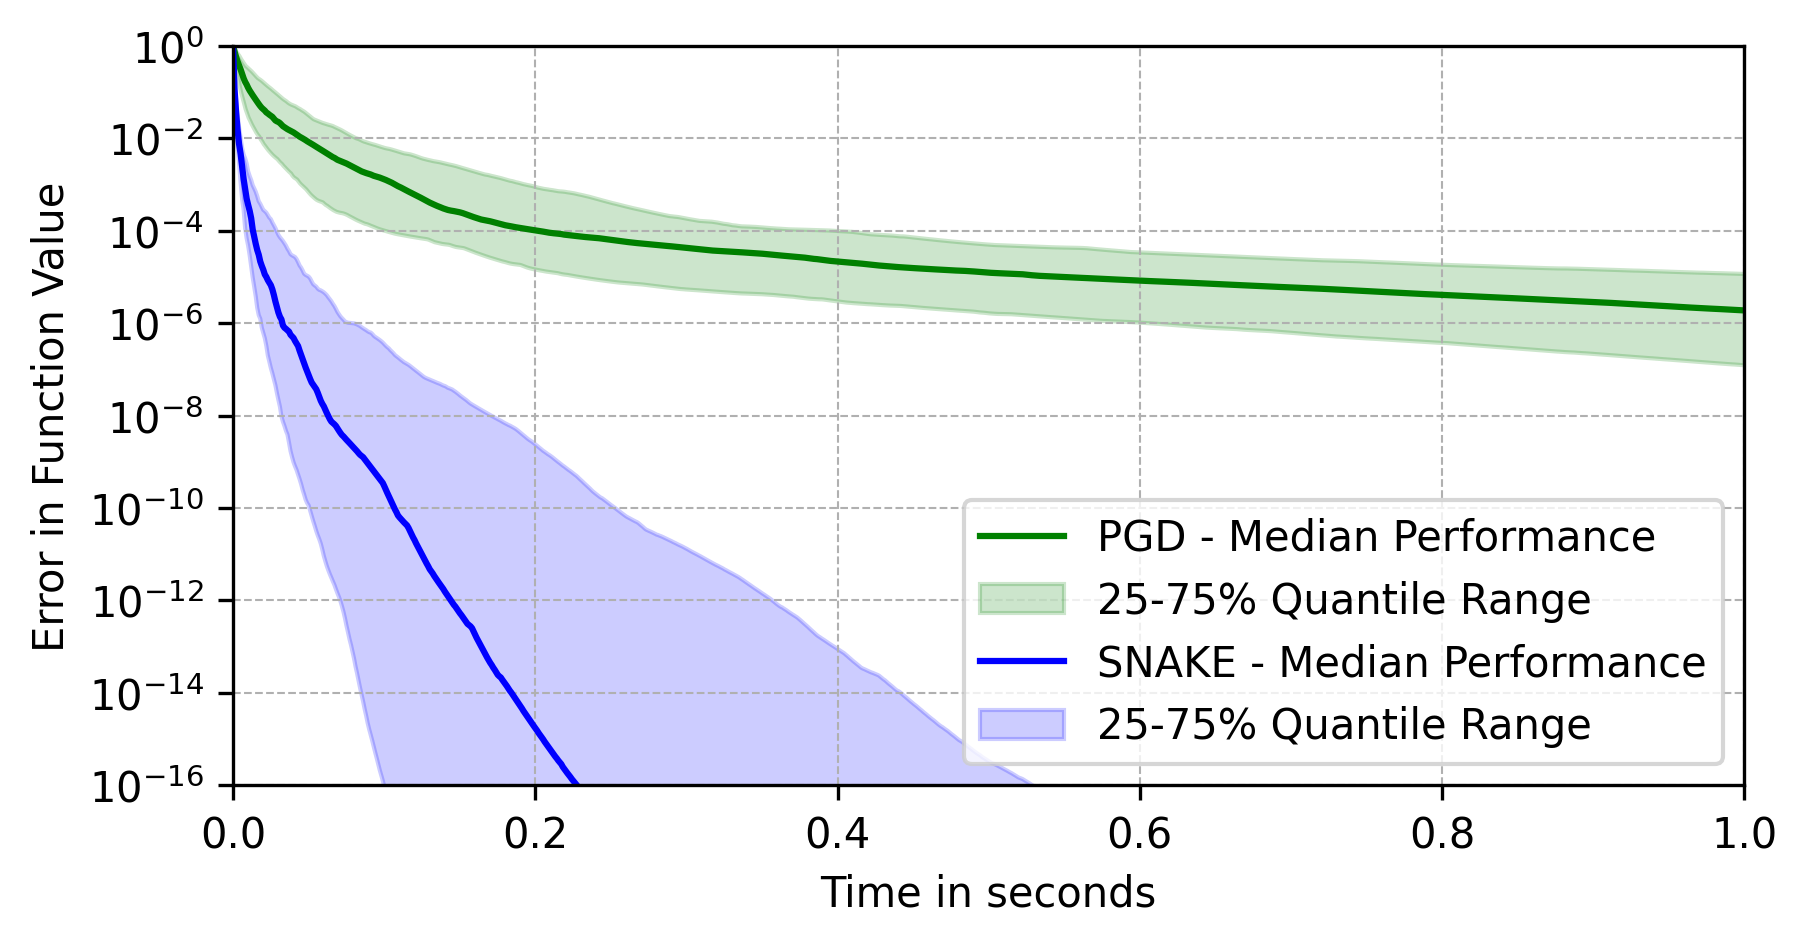

In [12]:

# Convert lists to NumPy arrays
all_values = np.array(snake_losses)
all_values2 = np.array(pgd_losses)

# Compute median and quantiles for both datasets
def compute_statistics(data):
    median = np.median(data, axis=0)
    q25 = np.percentile(data, 25, axis=0)
    q75 = np.percentile(data, 75, axis=0)
    return median, q25, q75

# Statistics for SNAKE and PGD
av, q_25, q_75 = compute_statistics(all_values)
av2, q2_25, q2_75 = compute_statistics(all_values2)

# Set y-ticks for logarithmic scale
yticks = [10**i for i in range(0, -17, -2)]
ytick_labels = [f'$10^{{{i}}}$' for i in range(0, -17, -2)]

# Plotting
plt.figure(figsize=(6.5, 3.2), dpi=300)
t = np.linspace(0, 1, 1000)

# Plot PGD
plt.plot(t, av2, label='PGD - Median Performance', color='green')
plt.fill_between(t, q2_25, q2_75, color='green', alpha=0.2, label='25-75% Quantile Range')

# Plot SNAKE
plt.plot(t, av, label='SNAKE - Median Performance', color='blue')
plt.fill_between(t, q_25, q_75, color='blue', alpha=0.2, label='25-75% Quantile Range')

# Customize plot
plt.xlabel('Time in seconds')
plt.ylabel('Error in Function Value')
plt.ylim(1e-16, 1)
plt.xlim(0, 1)

# Apply logarithmic scale
plt.yscale('log')
plt.yticks(yticks, ytick_labels)

# Add legend and grid
plt.legend(loc='lower right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()


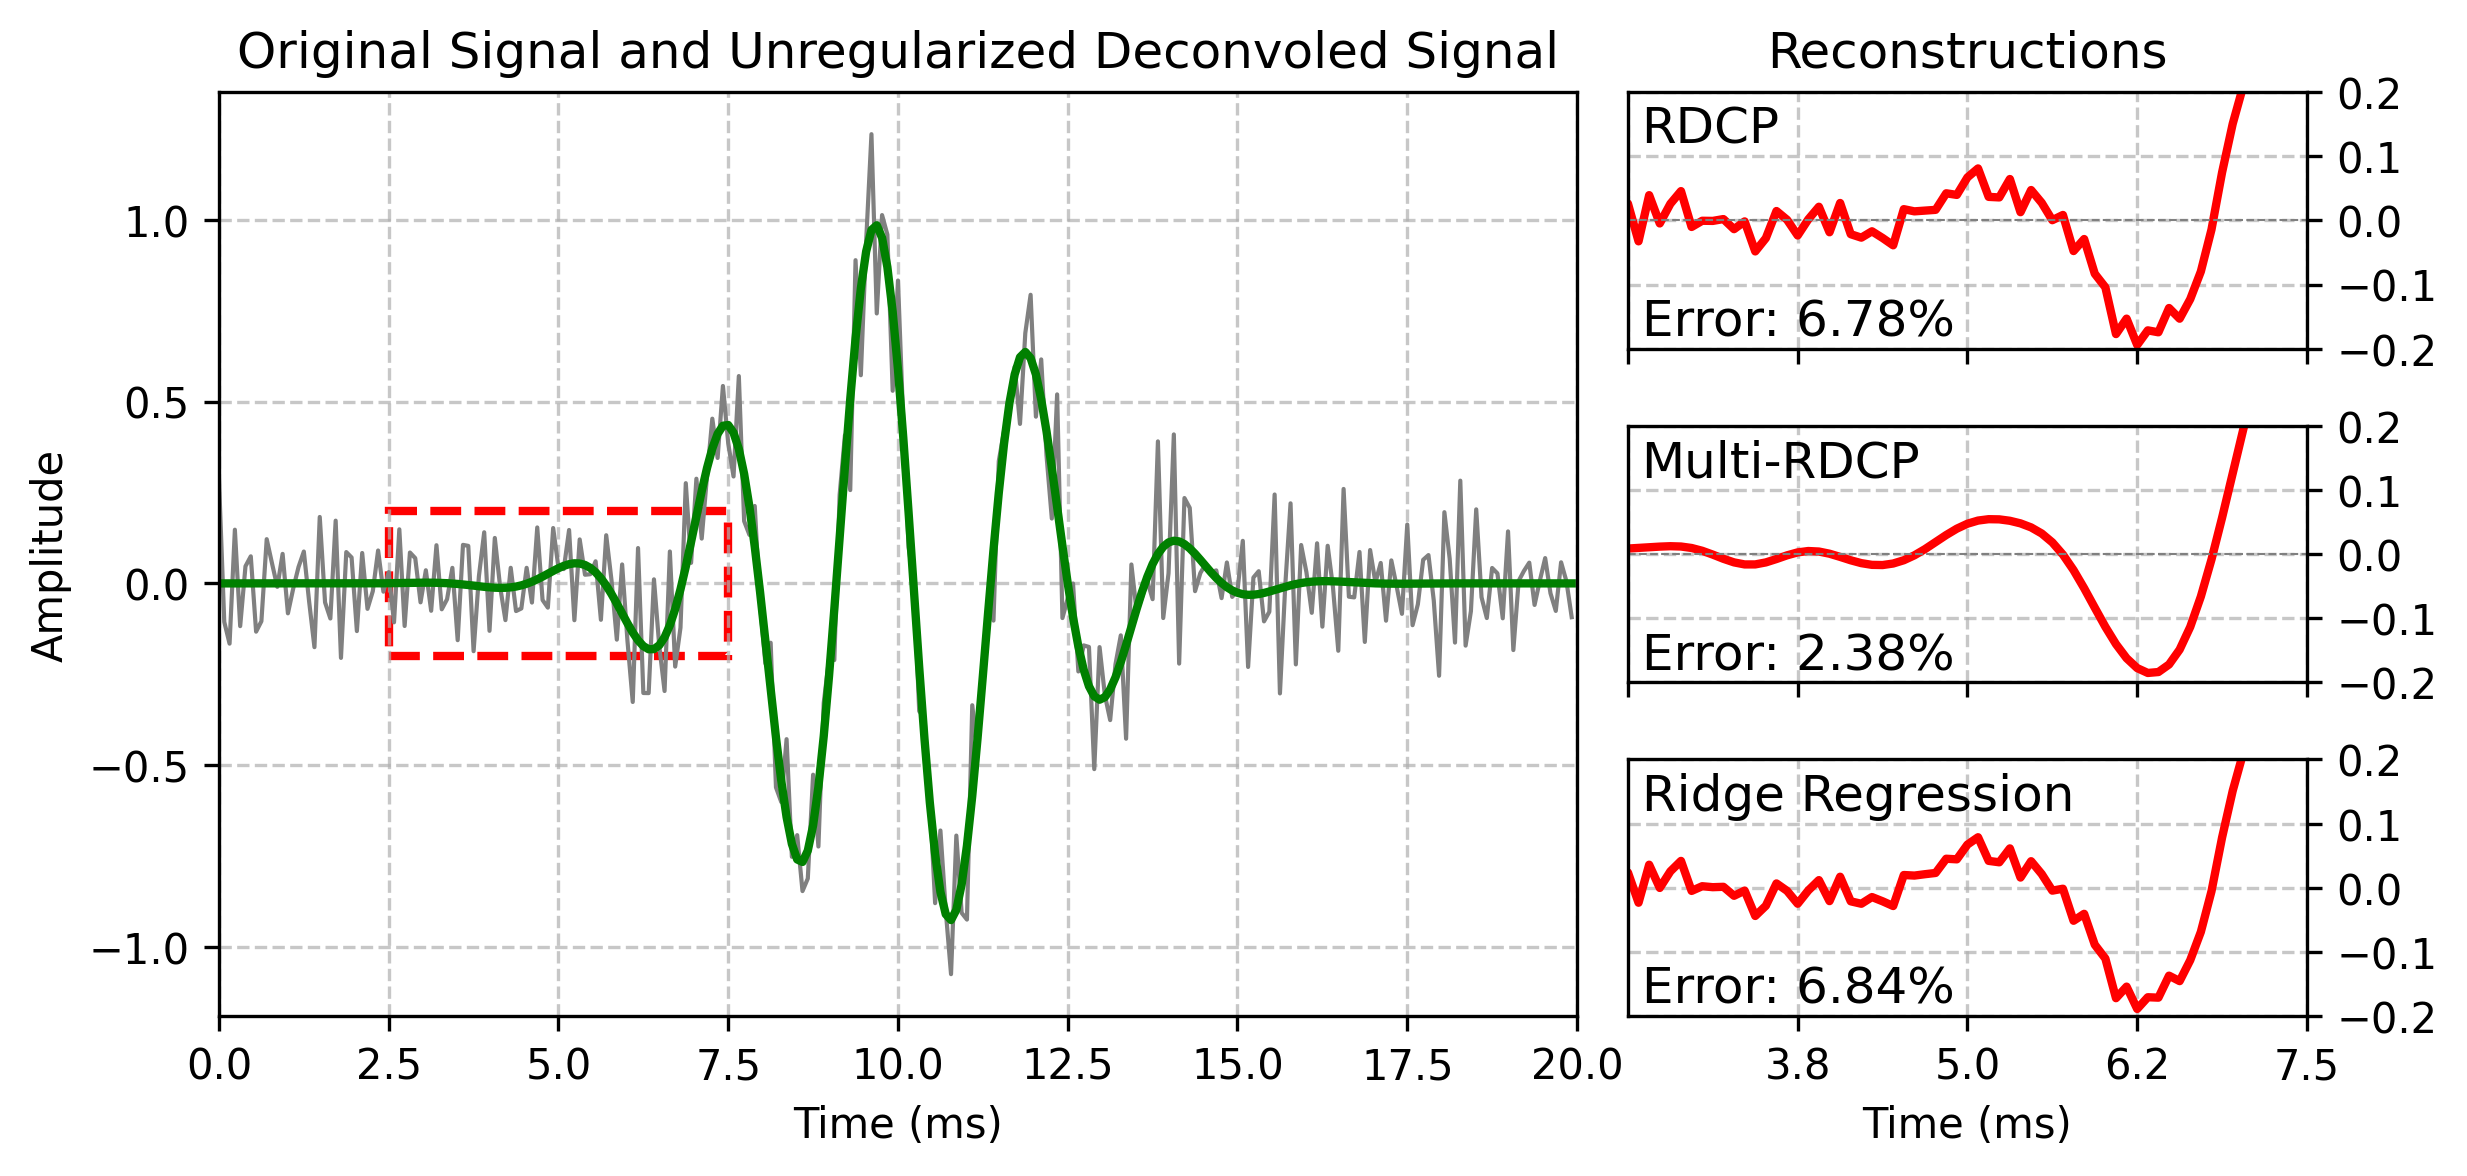

In [15]:


fig = plt.figure(figsize=(8, 4),dpi=300)


a = 76

gs = GridSpec(1, 2, width_ratios=[2, 1], wspace=0.05)

ax_left = fig.add_subplot(gs[0, 0])
t = np.linspace(0, duration, signal_length, endpoint=False)
ax_left.plot(t, noisy_signals[a], linewidth=1, color='grey')
ax_left.plot(t, signal, linewidth=2, color='green')


rect = patches.Rectangle(
    (0.0025, -0.2),
    0.005,
    0.4,
    linewidth=2,
    edgecolor='red',
    facecolor='none',
    linestyle='--'
)

ax_left.add_patch(rect)
ax_left.set_title('Original Signal and Unregularized Deconvoled Signal')
ax_left.set_xlabel('Time (s)')
ax_left.set_ylabel('Amplitude')
ax_left.grid(True, linestyle='--', alpha=0.7)  # Add gridlines for better readability


gs_right = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0, 1], hspace=0.3)


ax1 = fig.add_subplot(gs_right[0])
ax1.plot(t,  np.fft.ifft(pgd_reconstructions[a]).real, linewidth=2, color='red')
ax1.set_title(f'Reconstructions')
ax1.set_xticks([])
ax1.text(0.02, 0.95, 'RDCP', transform=ax1.transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='left')
ax1.text(0.02, 0.2, f'Error: {np.round(np.linalg.norm(pgd_reconstructions[a]-W)/np.linalg.norm(W)*100,2)}%', transform=ax1.transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='left')
ax1.axhline(0, color='gray', linewidth=0.5, linestyle='--')



ax2 = fig.add_subplot(gs_right[1])
ax2.plot(t,  np.fft.ifft(snake_reconstructions[a]).real, linewidth=2, color='red')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xticks([])
ax2.text(0.02, 0.95, 'Multi-RDCP', transform=ax2.transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='left')
ax2.text(0.02, 0.2, f'Error: {np.round(np.linalg.norm(snake_reconstructions[a]-W)/np.linalg.norm(W)*100,2)}%', transform=ax2.transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='left')
ax2.axhline(0, color='gray', linewidth=0.5, linestyle='--')


ax3 = fig.add_subplot(gs_right[2])
ax3.plot(t, np.fft.ifft(ridge_reconstructions[a]).real, linewidth=2, color='red')
ax3.set_xlabel('Time (ms)')
ax3.text(0.02, 0.95, 'Ridge Regression', transform=ax3.transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='left')
ax3.text(0.02, 0.2, f'Error: {np.round(np.linalg.norm(ridge_reconstructions[a]-W)/np.linalg.norm(W)*100,2)}%', transform=ax3.transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='left')

for ax in [ax1, ax2, ax3]:
    ax.set_xlim(0.0025, 0.0075)
    ax.set_ylim(-0.2, 0.2)
    ax.yaxis.tick_right()

    ax.set_xticks(np.linspace(0.0025, 0.0075, 5))
    ax.tick_params(axis='x', labelbottom=False)

    xticks = ax.get_xticks()
    if ax == ax3:
        ax.set_xticks(xticks[1:])
        ax.set_xticklabels([f'{tick * 1000:.1f}' for tick in xticks[1:]])
        ax.set_xlabel('Time (ms)')
    ax.grid(True, which='both', axis='both', linestyle='--', alpha=0.7)
    ax.set_yticks(np.arange(-0.2, 0.21, 0.1))



ax3.tick_params(axis='x', labelbottom=True)
xticks = ax3.get_xticks()
ax3.set_xticklabels([f'{tick * 1000:.1f}' for tick in xticks])
ax_left.set_xlim(0, 0.02)
xticks_left = ax_left.get_xticks()
ax_left.set_xticks(xticks_left)
ax_left.set_xticklabels([f'{tick * 1000:.1f}' for tick in xticks_left])

ax_left.set_xlabel('Time (ms)')

plt.subplots_adjust(left=0.08, right=0.95, wspace=50)

plt.show()

In [18]:

# Function to calculate normalized error and find the index of the median error
def calculate_error(recon_list, reference_signal):
    errors = [
        np.linalg.norm(np.fft.ifft(recon).real - reference_signal) / np.linalg.norm(reference_signal)
        for recon in recon_list
    ]
    median_error = np.median(errors)
    sorted_indices = np.argsort(errors)
    median_position = len(errors) // 2  # Position in the sorted list
    median_index = sorted_indices[median_position]  # Actual index in original list
    return errors, median_error, median_index, sorted_indices

# List of reconstruction methods with labels
reconstructions = {
    'Multi-RDCP': snake_reconstructions,
    'RDCP': pgd_reconstructions,
    'Ridge Regression': ridge_reconstructions
}

error_data = {}
for label, recon_list in reconstructions.items():
    errors, median_error, median_index, sorted_indices = calculate_error(recon_list, signal)
    error_data[label] = errors
    print(f"{label}: Median Error = {median_error:.6f}, Index = {median_index}")



Multi-RDCP: Median Error = 0.023824, Index = 89
RDCP: Median Error = 0.069943, Index = 79
Ridge Regression: Median Error = 0.067720, Index = 36
